```
This software is a part of GPU Ocean.

Copyright (C) 2019  SINTEF Digital

This notebook is used to create figures that illustrates how the 
non-zero pattern for the covariance structure P allows us to do a 
local Singular-Value Decomposition.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# Figures for the non-zero pattern for the local SVD


## Set environment

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation, rc
from scipy.special import lambertw

import pycuda.driver as cuda

import os
import sys
import datetime
from importlib import reload

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../')))

#Set large figure sizes
rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 'size':16})
rc('text', usetex=True)
rc('xtick', labelsize=14)     
rc('ytick', labelsize=14)

matplotlib.rcParams['contour.negative_linestyle'] = 'solid'


#Import our simulator
from SWESimulators import CDKLM16, PlotHelper, Common, IPythonMagic, config

from SWESimulators import BathymetryAndICs as BC
from SWESimulators import OceanStateNoise
from SWESimulators import OceanNoiseEnsemble
from SWESimulators import BaseOceanStateEnsemble
from SWESimulators import DataAssimilationUtils as dautils
from SWESimulators import IEWPFOcean

#np.random.seed(8) # 8 was fine, but velocities the wrong way...
#np.random.seed(11) # 11 was fine also, but innovation straight north...
np.random.seed(25) # 11 was fine also, but innovation straight north...

In [2]:
%cuda_context_handler gpu_ctx

In [3]:
# Create folder for storing plots
imgdir='local_svd_' + datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
os.makedirs(imgdir)
imgdir = imgdir + "/"
print("Saving figures to " + imgdir)

Saving figures to local_svd_2019_09_22-16_09_29/


## Creating ensemble as a parameter basis

In [4]:

# DEFINE PARAMETERS

sim_args = {
    "gpu_ctx": gpu_ctx,
    "nx": 120, "ny": 120,
    #"nx": 15, "ny": 15,
    "dx": 4.0, "dy": 4.0,
    "dt": 0.05,
    "g": 9.81,
    "f": 0.05,
    "coriolis_beta": 0.0,
    "r": 0.0,
    "rk_order": 2,
    "small_scale_perturbation_amplitude": None,
    "write_netcdf": False, 
    "small_scale_perturbation": True,
    #"small_scale_perturbation_interpolation_factor": 1,
    "small_scale_perturbation_interpolation_factor": 5,
    "boundary_conditions": Common.BoundaryConditions(2,2,2,2)
}

ghosts = np.array([2,2,2,2]) # north, east, south, west
validDomain = np.array([2,2,2,2])


dataShape = (sim_args["ny"] + ghosts[0]+ghosts[2], 
             sim_args["nx"] + ghosts[1]+ghosts[3])
dataShapeHi = (sim_args["ny"] + ghosts[0]+ghosts[2]+1, 
             sim_args["nx"] + ghosts[1]+ghosts[3]+1)

sim_args["eta0"] = np.zeros(dataShape, dtype=np.float32, order='C');
sim_args["hv0"] = np.zeros(dataShape, dtype=np.float32, order='C');
sim_args["hu0"] = np.zeros(dataShape, dtype=np.float32, order='C');
waterDepth = 10.0
sim_args["H"] = np.ones(dataShapeHi, dtype=np.float32, order='C')*waterDepth


if 'sim' in globals(): 
    sim.cleanUp()
if 'ensemble' in globals():
    ensemble.cleanUp()
if 'iewpfOcean' in globals():
    iewpfOcean.cleanUp()
    
sim_args["small_scale_perturbation_amplitude"] = np.sqrt(sim_args["dt"])*0.5*sim_args["f"]/(sim_args["g"]*waterDepth)
sim_args["small_scale_perturbation_amplitude"] *= sim_args["small_scale_perturbation_interpolation_factor"]
print ("q0: ", sim_args["small_scale_perturbation_amplitude"])
print ("[f, g, H, dt]", [sim_args["f"], sim_args["g"], waterDepth, sim_args["dt"]])
print ("(nx, ny): ", (sim_args["nx"], sim_args["ny"]))

reload(CDKLM16)
reload(BaseOceanStateEnsemble)
reload(OceanNoiseEnsemble)
reload(PlotHelper)
reload(dautils)
reload(IEWPFOcean)

sim = CDKLM16.CDKLM16(**sim_args)

# Initial perturbation
rand_nx, rand_ny = sim.small_scale_model_error.rand_nx, sim.small_scale_model_error.rand_ny
init_rand = np.random.normal(size=(rand_ny, rand_nx))
sim.small_scale_model_error.random_numbers.upload(sim.gpu_stream, init_rand)
sim.small_scale_model_error.perturbSim(sim, q0_scale=100, update_random_field=False)
    
eta_init, hu_init, hv_init = sim.download(True)
    
ensemble_args = {
    "gpu_ctx": gpu_ctx,
    "numParticles": 5,
    "num_drifters": 1,
    "sim": sim,
    "observation_type": dautils.ObservationType.DirectUnderlyingFlow,
    "observation_variance": 0.015**2 #0.02**2
}

ensemble = OceanNoiseEnsemble.OceanNoiseEnsemble(**ensemble_args)

max_dt = ensemble.findLargestPossibleTimeStep()
print ("max_dt: ", max_dt)

iewpfOcean = IEWPFOcean.IEWPFOcean(ensemble, debug=False, show_errors=True)

print ("Ready!")
#ensemble.plotEnsemble()

q0:  0.00028492201548162456
[f, g, H, dt] [0.05, 9.81, 10.0, 0.05]
(nx, ny):  (120, 120)
max_dt:  0.08846497535705566
Ready!



# Investigating the innermost term of $P$

Step 2 of the IEWPF algorithm consists of drawing $\xi \sim N(0, P)$, meaning that we have to find $\xi = P^{1/2} \tilde{\xi}$, in which $\tilde{\xi} \sim N(0, I)$ and $P$ is given by
$$ P = Q - Q H^T (HQH^T + R)^{-1} H Q \\
	  \qquad = Q^{1/2}(I - Q^{1/2, T}H^T S H Q^{1/2})Q^{1/2,T} \\
      \qquad = Q^{1/2}(I - \tilde{P})Q^{1/2,T} $$
In order to find $P^{1/2}$, we need to express $(I - \tilde{P})^{1/2}$. This will be done through a singular value decomposition of $(I - \tilde{P})$.

By considering the local structure of $Q^{1/2}$ and the size of the size of the observation operator $H$, we see that $\tilde{P}$ will be matrix which is zero everywhere, except in a $7 \times 7$ neighbour block, where the location of the block depends on the position of the observed drifter. Since $H$ will change, $P$ is subject to change as well, but the structure of $P$ will be constant. We can therefore obtain $P^{1/2}$ based on the SVD of the non-zero block of $(I-\tilde{P})$. 


The aim of the code below is to obtain the full matrix $\tilde{P}$, and confirm that we can calculate the SVD of $(I - \tilde{P})$.
By using 
$$(I - \tilde{P}) = U \Sigma V^T,$$ 
where $\Sigma$ is a diagonal matrix, we now get 
$$P = Q^{1/2} U \Sigma^{1/2} \Sigma^{1/2} V^T Q^{1/2, T} \\
	  \quad \qquad = U_{GB} \tilde{Q}^{1/2} U \Sigma^{1/2} \Sigma^{1/2} V^T \tilde{Q}^{1/2} U_{GB}^T$$

Using the convention $P = P^{1/2} P^{1/2, T}$, we get a $\xi \sim N(0, P)$ as
$$ \xi  = U_{GB} \tilde{Q}^{1/2} U \Sigma^{1/2} \tilde{\xi}$$


25


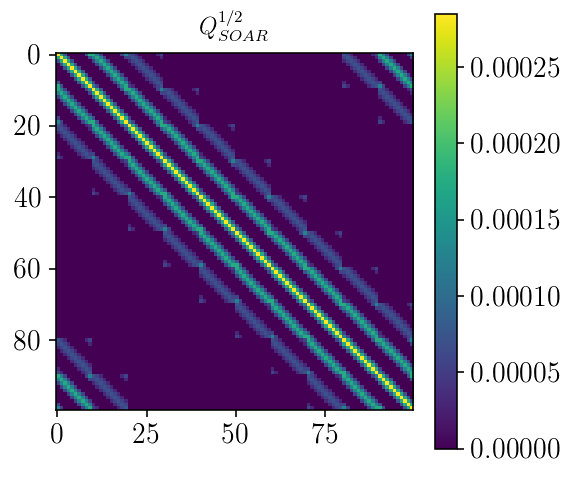

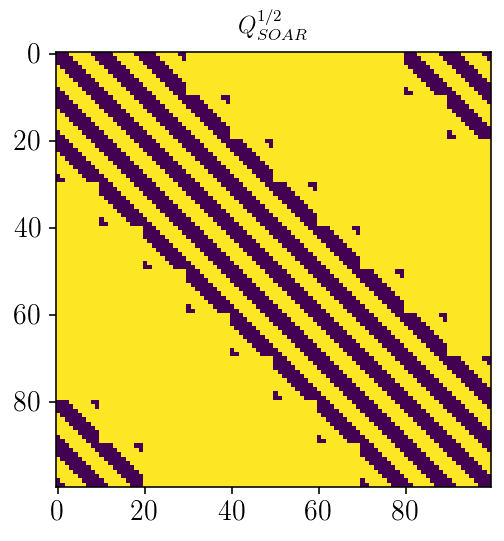

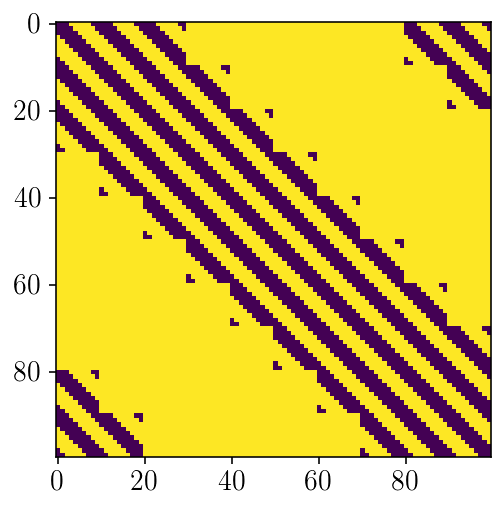

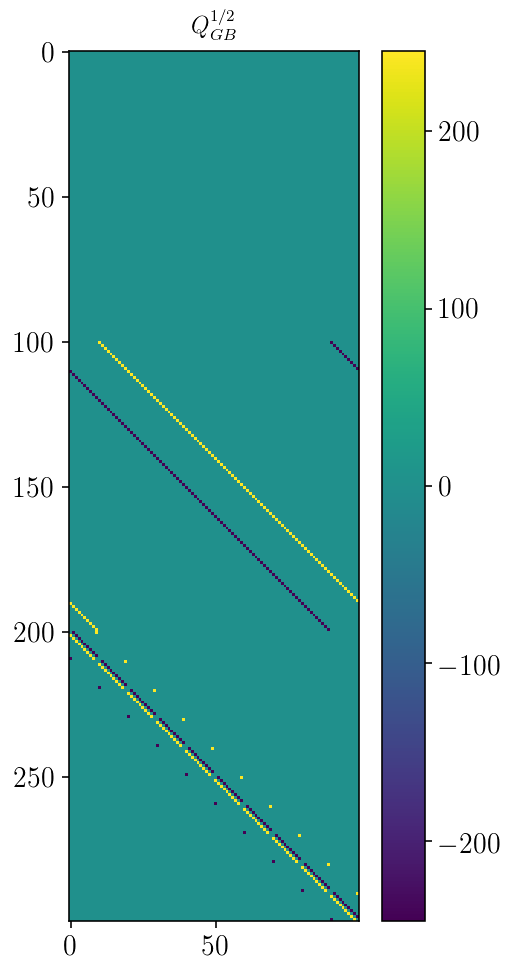

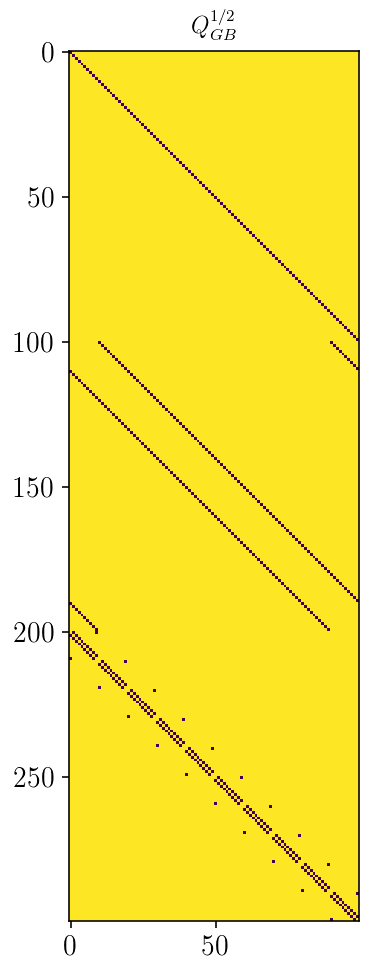

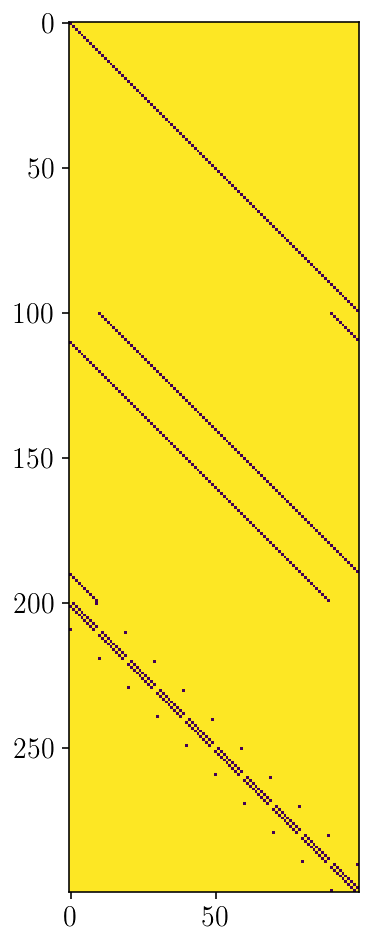

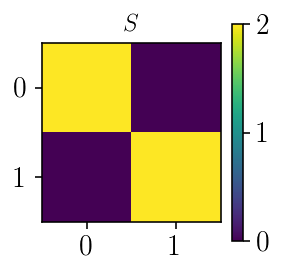

In [5]:
def periodic_SOAR_Q(a_x, a_y, b_x, b_y, dx, dy, nx, ny, q0, L):
    dist_x = min((a_x - b_x)**2, (a_x - (b_x + nx))**2, (a_x - (b_x - nx))**2)
    dist_y = min((a_y - b_y)**2, (a_y - (b_y + ny))**2, (a_y - (b_y - ny))**2)
    
    dist = np.sqrt( dx*dx*dist_x  +  dy*dy*dist_y)
    
    return q0*(1.0 + dist/L)*np.exp(-dist/L)

def createCutoffMatrixQ(nx, ny, dx=1.0, dy=1.0, q0=1.0, L=1.0, cutoff=2):
    Q = np.zeros((ny*nx, ny*nx))
    for a_y in range(ny):
        for a_x in range(nx):
            j = a_y*nx + a_x
            for b_y in range(a_y-cutoff, a_y+cutoff+1):
                if b_y < 0:    
                     b_y = b_y + ny
                if b_y > ny-1: 
                    b_y = b_y - ny
                for b_x in range(a_x-cutoff, a_x+cutoff+1):
                    if b_x < 0:
                        b_x = b_x + nx
                    if b_x > nx-1: 
                        b_x = b_x - nx
                    i = b_y*nx + b_x
                    Q[j, i] = periodic_SOAR_Q(a_x, a_y, b_x, b_y, dx, dy, nx, ny, q0, L)
    return Q

def createFullMatrixQ(nx, ny, dx=1, dy=1, q0=1, L=1):
    Q = np.zeros((ny*nx, ny*nx))
    for a_y in range(ny):
        for a_x in range(nx):
            j = a_y*nx + a_x
            for b_y in range(ny):
                for b_x in range(nx):
                    i = b_y*nx + b_x
                    Q[j, i] = periodic_SOAR_Q(a_x, a_y, b_x, b_y, dx, dy, nx, ny, q0, L)
    return Q

nx = 10
ny = 10
dx = ensemble.dx
dy = ensemble.dy
L = 0.75*dx
g = ensemble.g
q0 = ensemble.small_scale_perturbation_amplitude
Q = createCutoffMatrixQ(nx, ny, dx, dy, q0=q0, L=L)

fig = plt.figure(figsize=(4,4))
plt.imshow(Q, interpolation="None")
plt.title(r'$Q_{SOAR}^{1/2}$')
plt.colorbar()
plt.savefig(imgdir + "SOAR.pdf", bbox_inches="tight", format='pdf')


fig = plt.figure(figsize=(4,4))
plt.imshow(Q == 0.0, interpolation="None")
plt.title(r'$Q_{SOAR}^{1/2}$')
plt.savefig(imgdir + "SOAR_nnz.pdf", bbox_inches="tight", format='pdf')

fig = plt.figure(figsize=(4,4))
plt.imshow(Q == 0.0, interpolation="None")
plt.savefig(imgdir + "SOAR_nnz_nt.pdf", bbox_inches="tight", format='pdf')


#fullQ = createFullMatrixQ(nx, ny, L=L, q0=q0)
#fig = plt.figure(figsize=(4,4))
#plt.imshow(fullQ, interpolation="None")
#plt.title("SOAR Q (full)")
#plt.colorbar()
#fig = plt.figure(figsize=(4,4))
#plt.imshow(Q - fullQ, interpolation="None")
#plt.colorbar()
#plt.title("SOAR Q (cutoff - diff)")



def createUGBmatrix(nx, ny, g=9.81, H=10, f=30, dx=1.0, dy=1.0):
    I = np.eye(nx*ny)
    A_hu = np.zeros((ny*nx, ny*nx))
    A_hv = np.zeros((ny*nx, ny*nx))
    for a_y in range(ny):
        for a_x in range(nx):
            i = a_y*nx + a_x
            
            # geo balance for hu:
            j = (a_y+1)*nx + a_x
            if a_y == ny-1:
                j = 0*nx + a_x
            A_hu[j,i] = 1.0
            j = (a_y-1)*nx + a_x
            if a_y == 0:
                j = (ny-1)*nx + a_x
            A_hu[j,i] = -1.0
            
            # geo balance for hv:
            j = a_y*nx + a_x + 1
            if a_x == nx-1:
                j = a_y*nx + 0
            A_hv[j,i] = 1.0
            
            j = a_y*nx + a_x - 1
            if a_x == 0:
                j = a_y*nx + nx - 1
            A_hv[j,i] = -1.0
            
    A_hu *= -g*H/(f*2*dx)
    A_hv *=  g*H/(f*2*dy)
            
    return np.bmat([[I], [A_hu], [A_hv]])


    
U = createUGBmatrix(nx, ny, g=g, H=waterDepth, f=ensemble.f, dx=dx, dy=dy)
fig = plt.figure(figsize=(4,8))
plt.imshow(U, interpolation="None")
plt.title(r'$Q_{GB}^{1/2}$')
plt.colorbar()
plt.savefig(imgdir + "GB.pdf", bbox_inches="tight", format='pdf')


fig = plt.figure(figsize=(4,8))
plt.imshow(U==0, interpolation="None")
plt.title(r'$Q_{GB}^{1/2}$')
plt.savefig(imgdir + "GB_nnz.pdf", bbox_inches="tight", format='pdf')

fig = plt.figure(figsize=(4,8))
plt.imshow(U==0, interpolation="None")
plt.savefig(imgdir + "GB_nnz_nt.pdf", bbox_inches="tight", format='pdf')


S = np.matrix([[2.0, 0.0], [0.0, 2.0]])
fig = plt.figure(figsize=(2,2))
plt.imshow(S, interpolation="None")
plt.title(r'$S$')
plt.colorbar()


print( np.sum(Q[50,:] != 0))




H.shape (2, 300)


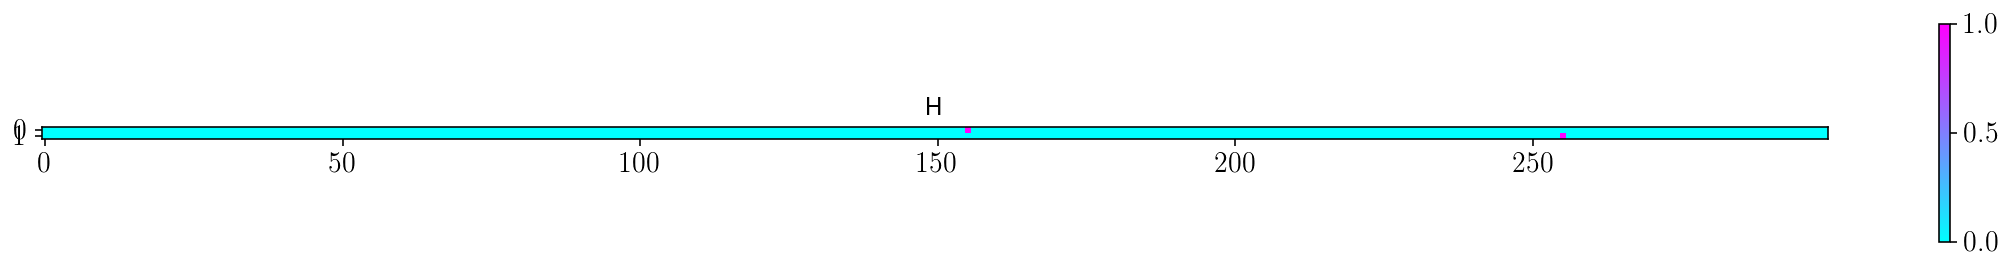

In [6]:

pos_x, pos_y = 5, 5
#pos_x, pos_y = cell_id_x, cell_id_y

def createMatrixH(nx, ny, pos_x, pos_y):
    H = np.zeros((2, 3*nx*ny))
    index = pos_y*nx + pos_x
    H[0, 1*nx*ny + index] = 1
    H[1, 2*nx*ny + index] = 1
    return H

H = createMatrixH(nx, ny, pos_x, pos_y)
print( "H.shape", H.shape)
fig = plt.figure(figsize=(20,2))
plt.imshow(H, interpolation="None", cmap="cool")
plt.title("H")
plt.colorbar()

Using $Q = U_{GB} \tilde{Q}^{1/2} \tilde{Q}^{1/2} U_{GB}^T$, where $\tilde{Q}^{1/2}$ is symmetric, we get 
$$\tilde{P} = \tilde{Q}^{1/2} U_{GB}^T H^T S H U_{GB} \tilde{Q}^{1/2}$$

We go through the computations ofÂ $\tilde{P}$ step by step

30


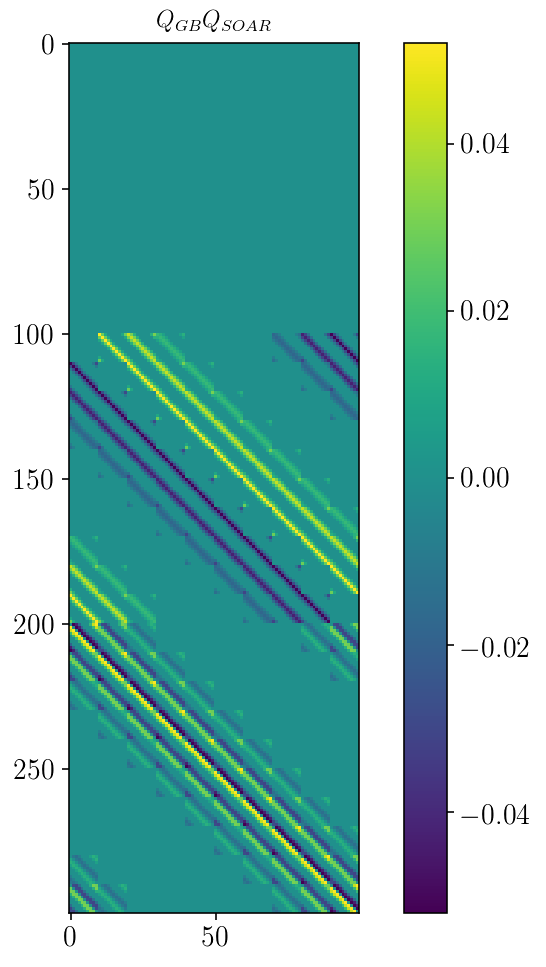

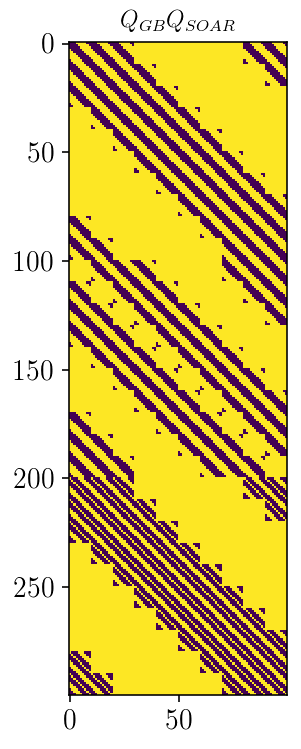

In [7]:
UQ = np.matmul(U, Q)
fig = plt.figure(figsize=(8,8))
plt.imshow(UQ, interpolation="None")
plt.title(r'$Q_{GB} Q_{SOAR}$')
plt.colorbar()
plt.savefig(imgdir + "GB_SOAR.pdf", bbox_inches="tight", format='pdf')


fig = plt.figure(figsize=(3,6))
plt.imshow(UQ == 0.0, interpolation="None")
plt.title(r'$Q_{GB} Q_{SOAR}$')
plt.savefig(imgdir + "GB_SOAR_nnz.pdf", bbox_inches="tight", format='pdf')


print (np.sum(UQ[150,:] != 0))


[[30]
 [30]]


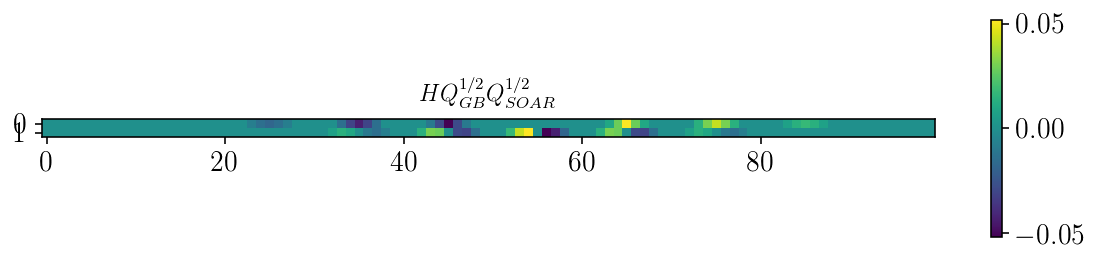

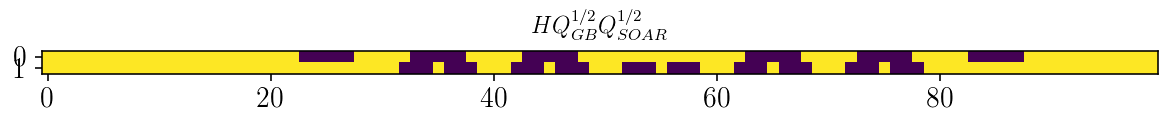

In [8]:
HUQ = np.matmul(H, UQ)
fig = plt.figure(figsize=(10,2))
plt.imshow(HUQ, interpolation="None")
plt.title(r'$H Q^{1/2}_{GB} Q^{1/2}_{SOAR}$')
plt.colorbar()
plt.savefig(imgdir + "H_GB_SOAR.pdf", bbox_inches="tight", format='pdf')

print (np.sum(HUQ != 0.0, axis=1))

fig = plt.figure(figsize=(10,2))
plt.imshow(HUQ==0, interpolation="None")
plt.title(r'$H Q^{1/2}_{GB} Q^{1/2}_{SOAR}$')
plt.savefig(imgdir + "H_GB_SOAR_nnz.pdf", bbox_inches="tight", format='pdf')


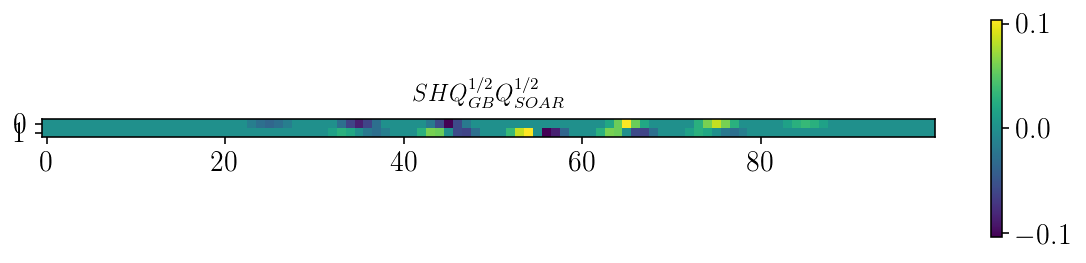

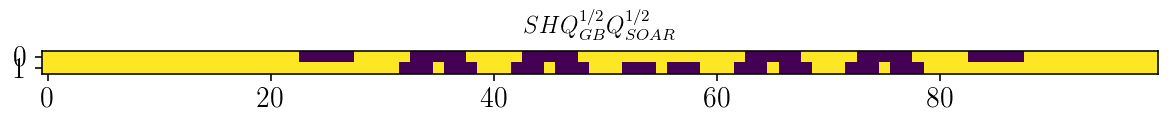

In [9]:
SHUQ = np.matmul(S, HUQ)
fig = plt.figure(figsize=(10,2))
plt.imshow(SHUQ, interpolation="None")
plt.title(r'$S H Q^{1/2}_{GB} Q^{1/2}_{SOAR}$')
plt.colorbar()
plt.savefig(imgdir + "S_H_GB_SOAR.pdf", bbox_inches="tight", format='pdf')

fig = plt.figure(figsize=(10,2))
plt.imshow(SHUQ==0, interpolation="None")
plt.title(r'$S H Q^{1/2}_{GB} Q^{1/2}_{SOAR}$')
plt.savefig(imgdir + "S_H_GB_SOAR_nnz.pdf", bbox_inches="tight", format='pdf')


30
30


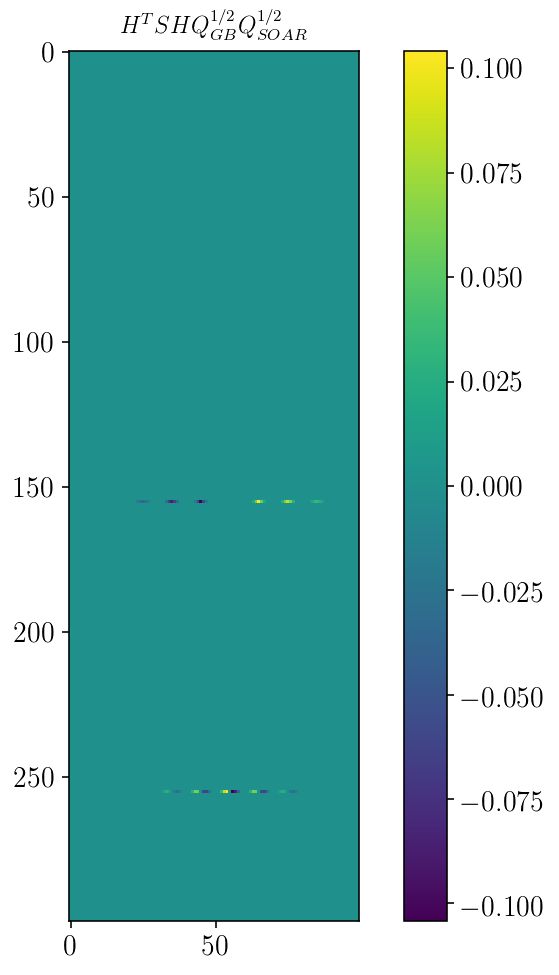

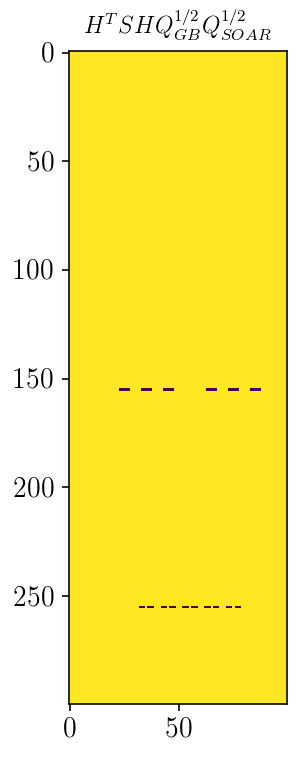

In [10]:
HTSHUQ = np.matmul(H.transpose(), SHUQ)
fig = plt.figure(figsize=(8,8))
plt.imshow(HTSHUQ, interpolation="None")
plt.title(r'$H^T S H Q^{1/2}_{GB} Q^{1/2}_{SOAR}$')
plt.savefig(imgdir + "H_S_H_GB_SOAR.pdf", bbox_inches="tight", format='pdf')

plt.colorbar()
for i in range(300):
    nnz =  np.sum( HTSHUQ[i,:] != 0)
    if nnz != 0: print( nnz)
    
fig = plt.figure(figsize=(3,6))
plt.imshow(HTSHUQ==0, interpolation="None")
plt.title(r'$H^T S H Q^{1/2}_{GB} Q^{1/2}_{SOAR}$')
plt.savefig(imgdir + "H_S_H_GB_SOAR_nnz.pdf", bbox_inches="tight", format='pdf')


30
30
30
30


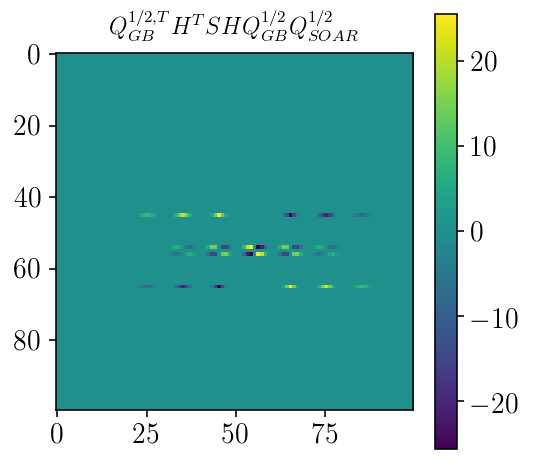

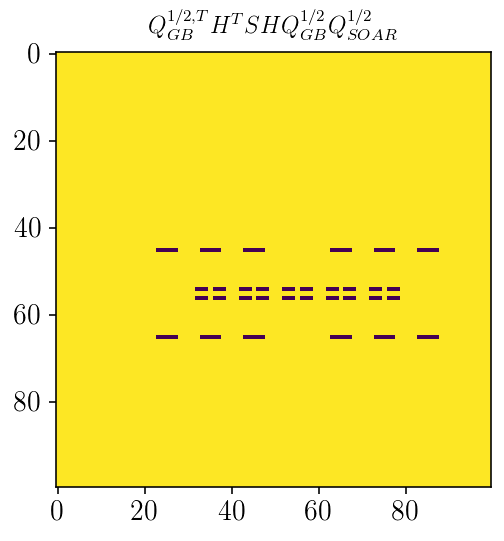

In [11]:
UTHTSHUQ = np.matmul(U.transpose(), HTSHUQ)
fig = plt.figure(figsize=(4,4))
plt.imshow(UTHTSHUQ, interpolation="None")
plt.title(r'$Q^{1/2,T}_{GB} H^T S H Q^{1/2}_{GB} Q^{1/2}_{SOAR}$')
plt.savefig(imgdir + "GB_H_S_H_GB_SOAR.pdf", bbox_inches="tight", format='pdf')

plt.colorbar()
fig = plt.figure(figsize=(4,4))
plt.imshow(UTHTSHUQ==0, interpolation="None")
plt.title(r'$Q^{1/2,T}_{GB} H^T S H Q^{1/2}_{GB} Q^{1/2}_{SOAR}$')
plt.savefig(imgdir + "GB_H_S_H_GB_SOAR_nnz.pdf", bbox_inches="tight", format='pdf')

for i in range(100):
    nnz =  np.sum( UTHTSHUQ[i,:] != 0)
    if nnz != 0: print (nnz)

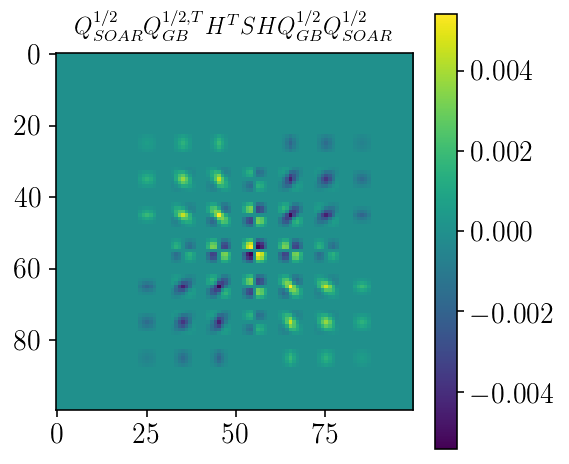

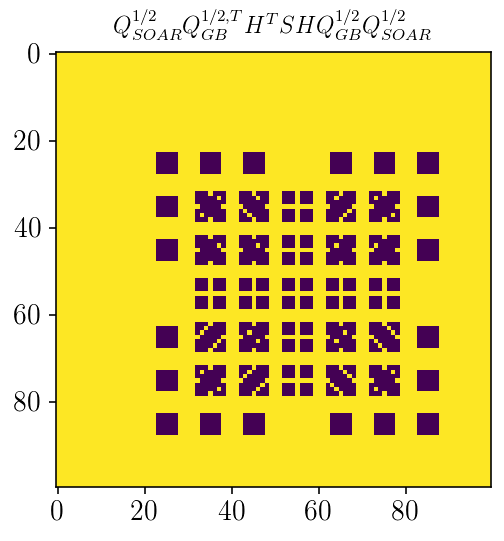

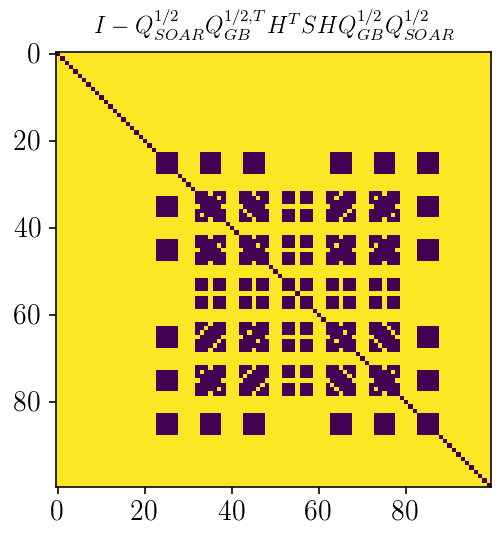

In [12]:
tildeP = np.matmul(Q, UTHTSHUQ)
fig = plt.figure(figsize=(4,4))
plt.imshow(tildeP, interpolation="None")
plt.title(r'$Q^{1/2}_{SOAR} Q^{1/2,T}_{GB} H^T S H Q^{1/2}_{GB} Q^{1/2}_{SOAR}$')
plt.colorbar()
plt.savefig(imgdir + "SOAR_GB_H_S_H_GB_SOAR.pdf", bbox_inches="tight", format='pdf')


fig = plt.figure(figsize=(4,4))
plt.imshow(tildeP == 0, interpolation="None")
plt.title(r'$Q^{1/2}_{SOAR} Q^{1/2,T}_{GB} H^T S H Q^{1/2}_{GB} Q^{1/2}_{SOAR}$')
plt.savefig(imgdir + "SOAR_GB_H_S_H_GB_SOAR_nnz.pdf", bbox_inches="tight", format='pdf')

printall = False
if printall:
    for i in range(100):
        nnz_row =  np.sum( tildeP[i,:] != 0)
        nnz_col =  np.sum( tildeP[:,i] != 0)
        if nnz_row != 0: print ("non-zeros in row " + str(i) + ": , " + str(nnz_row))
        if nnz_col != 0: print ("non-zeros in col " + str(i) + ": , " + str(nnz_col))
        if nnz_col != 0: print (" ")
            
            
IminTildeP = np.eye(100) - tildeP

fig = plt.figure(figsize=(4,4))
plt.imshow(IminTildeP == 0, interpolation="None")
plt.title(r'$I - Q^{1/2}_{SOAR} Q^{1/2,T}_{GB} H^T S H Q^{1/2}_{GB} Q^{1/2}_{SOAR}$')
plt.savefig(imgdir + "I_SOAR_GB_H_S_H_GB_SOAR_nnz.pdf", bbox_inches="tight", format='pdf')



In [13]:
print(np.eye(10))

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


tildeP_block.shape (49, 49)


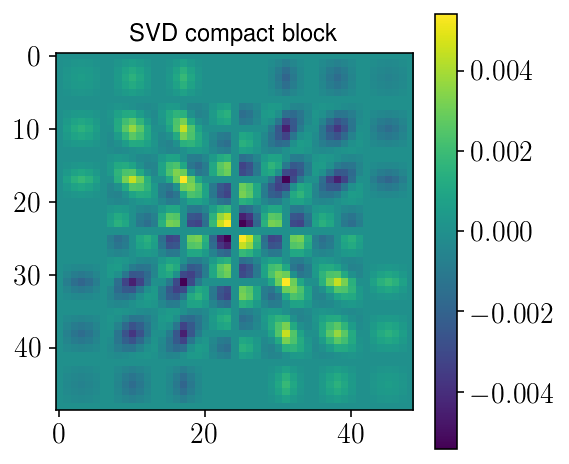

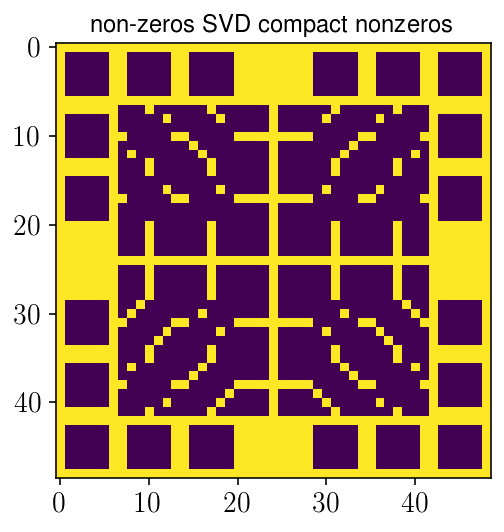

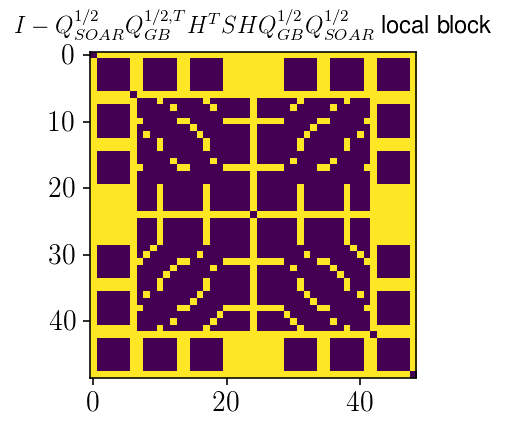

In [14]:
 def extractNonZeroBlocks(tildeP, nx, ny, pos_x, pos_y):
    
    # The Q^{1/2} U_GB^T pattern spreads information to a 7x7 cell area, but without the corners
    # Hence, the nonzero structure of tilde{P} should be a block of 7x7-4 = 49-4 = 45 rows and cells.
    
    # Strategy: Fill 49 by 49 area
    
    tildeP_block = np.zeros((49,49))
    
    # Read the non-zero structure from tildeP to tildeP_block
    for loc_y_j in range(7):
        global_y_j = pos_y - 3 + loc_y_j
        for loc_x_j in range(7):
            global_x_j = pos_x - 3 + loc_x_j
            
            global_j = global_y_j*nx + global_x_j
            local_j = loc_y_j*7 + loc_x_j
            
            for loc_y_i in range(7):
                global_y_i = pos_y - 3 + loc_y_i
                for loc_x_i in range(7):
                    global_x_i = pos_x - 3 + loc_x_i
                    
                    global_i = global_y_i*nx + global_x_i
                    local_i = loc_y_i*7 + loc_x_i
                    
                    tildeP_block[local_j, local_i] = tildeP[global_j, global_i] 
    
    # Delete the rows and arrays that should not take part of the block
    #local_indices_to_delete = [0, 6, 49-7, 49-1]
    #tildeP_block = np.delete(tildeP_block, local_indices_to_delete, 0)
    #tildeP_block = np.delete(tildeP_block, local_indices_to_delete, 1)
    
    validate = False
    if validate:
        nz_y, nz_x = np.nonzero(tildeP)
        print (len(nz_y), nz_y)
        print (len(nz_x), nz_x)
        print (7*7*7*7 )


        unique_nz_y = np.unique(nz_y)
        unique_nz_x = np.unique(nz_x)

        print( len(unique_nz_y), unique_nz_y)
        print( len(unique_nz_x), unique_nz_x)
        validation = tildeP[unique_nz_y, :]
        validation = validation[:, unique_nz_x]
        validation_nz_y, validation_nz_x = np.nonzero(validation)
        print ("Num nonzeros validation:  ", len(validation_nz_y), len(validation_nz_x))

        fig = plt.figure(figsize=(4,4))
        plt.imshow(validation, interpolation="None")
        plt.title("validation for tilde(P) non-zeros block")
        plt.colorbar()

        fig = plt.figure(figsize=(4,4))
        plt.imshow(tildeP_block, interpolation="None")
        plt.title("tildeP_block")
        plt.colorbar()

        fig = plt.figure(figsize=(4,4))
        plt.imshow(tildeP_block - validation, interpolation="None")
        plt.title("tildeP_block - validation")
        plt.colorbar()
    
    return tildeP_block
    
    
tildeP_block = extractNonZeroBlocks(tildeP, nx, ny, pos_x, pos_y )
fig = plt.figure(figsize=(4,4))
plt.imshow(tildeP_block, interpolation="None")
plt.title("SVD compact block")
plt.colorbar()
plt.savefig(imgdir + "SOAR_GB_H_S_H_GB_SOAR_local.pdf", bbox_inches="tight", format='pdf')


fig = plt.figure(figsize=(4,4))
plt.imshow(tildeP_block == 0, interpolation="None")
plt.title("non-zeros SVD compact nonzeros")
plt.savefig(imgdir + "SOAR_GB_H_S_H_GB_SOAR_local_nnz.pdf", bbox_inches="tight", format='pdf')


print ("tildeP_block.shape", tildeP_block.shape)

            
IminTildeP_block = np.eye(49) - tildeP_block

fig = plt.figure(figsize=(3,3))
plt.imshow(IminTildeP_block == 0, interpolation="None")
plt.title(r'$I - Q^{1/2}_{SOAR} Q^{1/2,T}_{GB} H^T S H Q^{1/2}_{GB} Q^{1/2}_{SOAR}$ local block')
plt.savefig(imgdir + "I_SOAR_GB_H_S_H_GB_SOAR_local_nnz.pdf", bbox_inches="tight", format='pdf')


# Finding the Singular-Value Decomposition

Need the SVD so that 
$$ (I - \tilde{P}) = U \Sigma V^T = U \Sigma^{1/2} \Sigma^{1/2} V^T $$

u:  (49, 49)
s:  (49,)
vh: (49, 49)
[1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         0.96186345
 0.96186345]


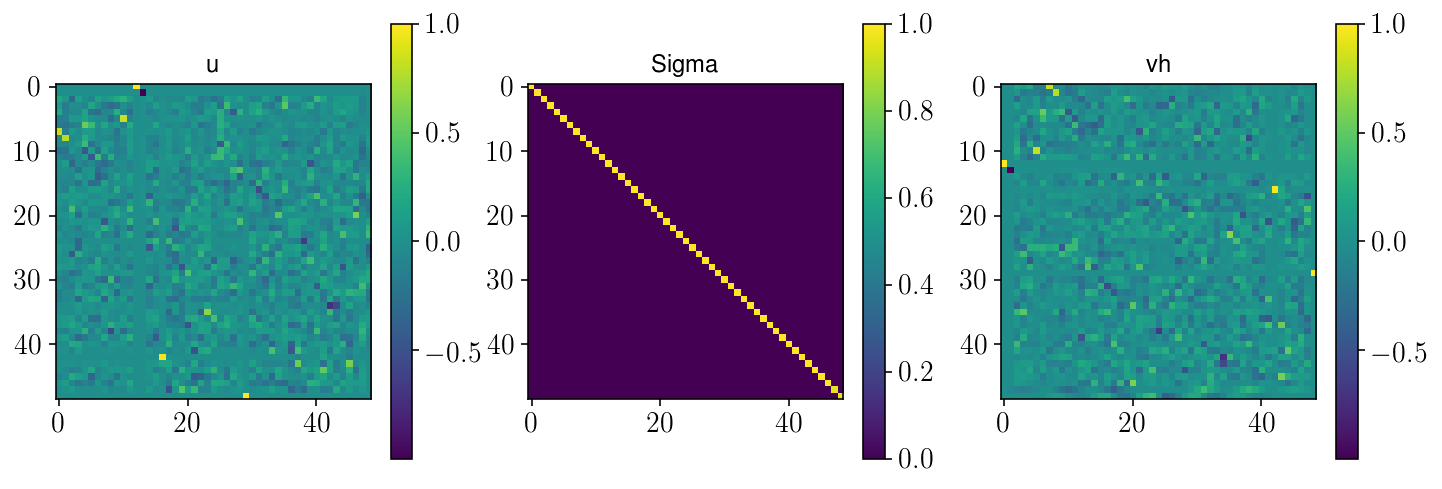

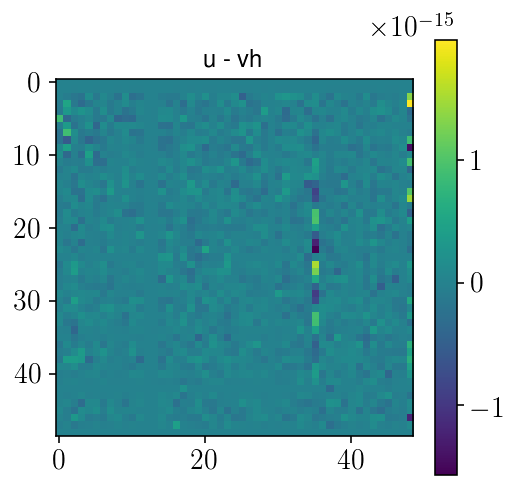

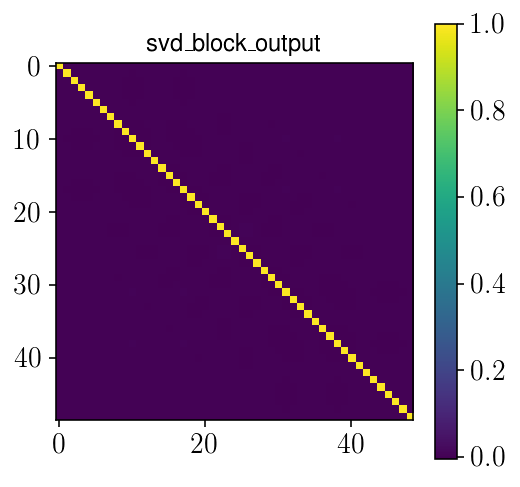

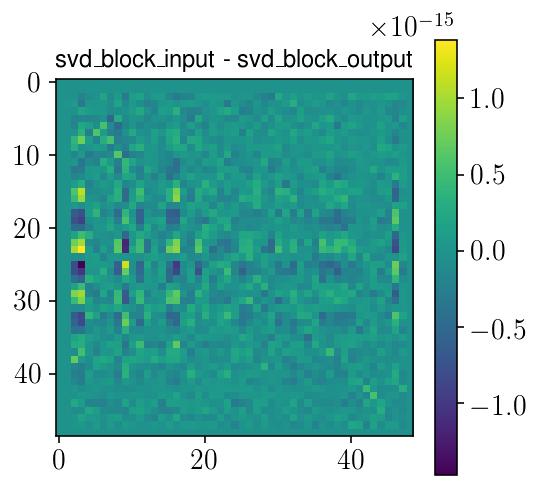

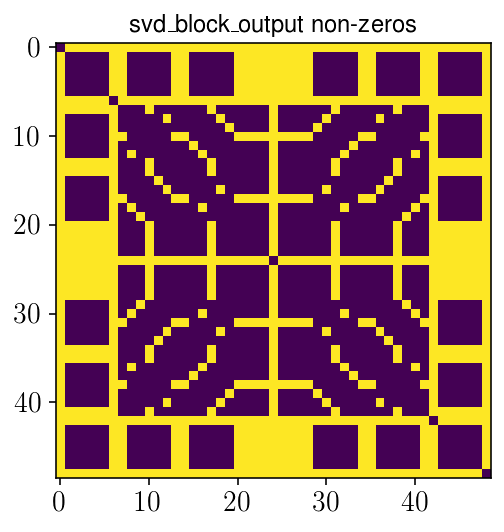

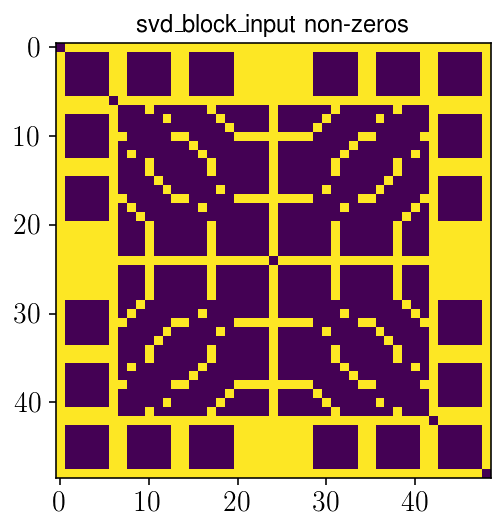

In [15]:
svd_block_input = np.eye(49) - tildeP_block
u, s, vh = np.linalg.svd(svd_block_input, full_matrices=True)

print( "u: ", u.shape)
print( "s: ", s.shape)
print( "vh:", vh.shape)

fig = plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(u, interpolation="None")
plt.title("u")
plt.colorbar()
plt.subplot(132)
plt.imshow(np.diag(s), interpolation="None")
plt.title("Sigma")
plt.colorbar()
plt.subplot(133)
plt.imshow(vh, interpolation="None")
plt.title("vh")
plt.colorbar()

fig = plt.figure(figsize=(4,4))
plt.imshow(u - vh.transpose(), interpolation="None")
plt.title("u - vh")
plt.colorbar()

svd_block_output = np.matmul(u, np.matmul(np.diag(s), vh))
fig = plt.figure(figsize=(4,4))
plt.imshow(svd_block_output, interpolation="None")
plt.title("svd\_block\_output")
plt.colorbar()

fig = plt.figure(figsize=(4,4))
plt.imshow(svd_block_input - svd_block_output, interpolation="None")
plt.title("svd\_block\_input - svd\_block\_output")
plt.colorbar()


fig = plt.figure(figsize=(4,4))
plt.imshow(np.abs(svd_block_output) < 0.00000001, interpolation="None")
plt.title("svd\_block\_output non-zeros")
fig = plt.figure(figsize=(4,4))
plt.imshow(np.abs(svd_block_input) < 0.00000001, interpolation="None")
plt.title("svd\_block\_input non-zeros")



print (s)

sqrt_term.shape (49, 49)
svd_tests/local_sqrt_term_nx_10_ny_10_posx_5_posy_5.npy


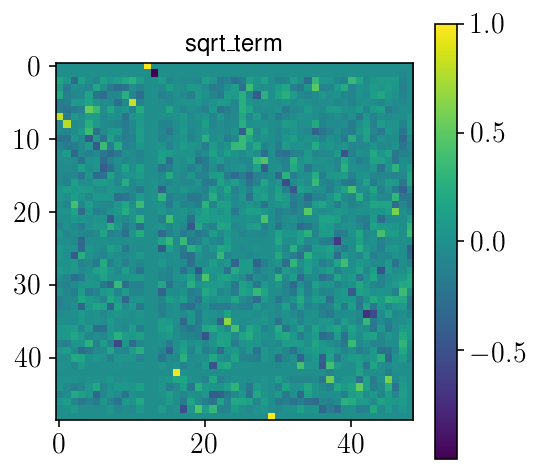

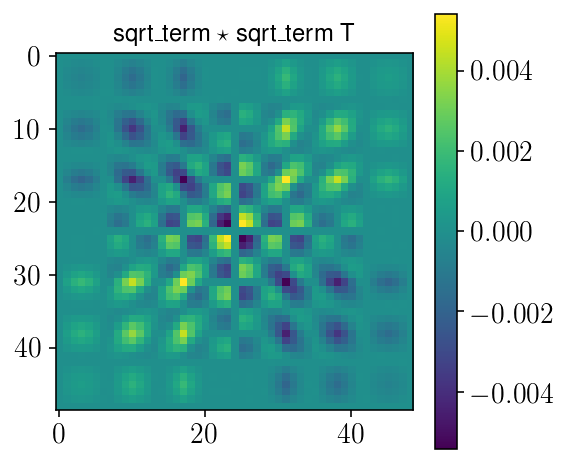

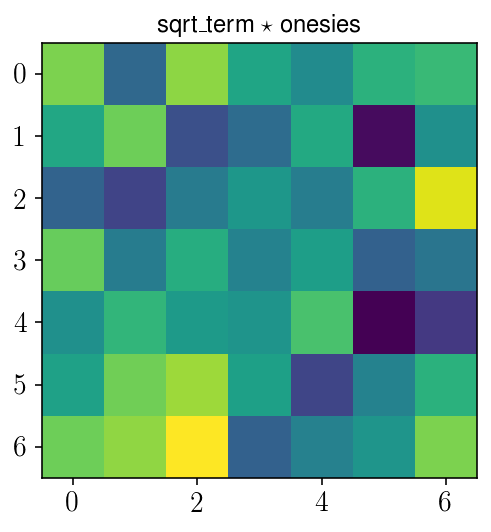

In [16]:
sqrt_term = np.matmul(u, np.diag(np.sqrt(s)))

fig = plt.figure(figsize=(4,4))
plt.imshow(sqrt_term, interpolation="None")
plt.title("sqrt\_term")
plt.colorbar()

fig = plt.figure(figsize=(4,4))
plt.imshow(np.dot(sqrt_term, sqrt_term.transpose()) - np.eye(49), interpolation="None")
plt.title("sqrt\_term $\star$ sqrt\_term T")
plt.colorbar()

onesies = np.ones(49)
onesies = np.dot(sqrt_term, onesies)
onesies = onesies.reshape((7,7))
fig = plt.figure(figsize=(4,4))
plt.imshow(onesies, interpolation="None")
plt.title("sqrt\_term $\star$ onesies")

print ("sqrt_term.shape", sqrt_term.shape)

filename = "svd_tests/local_sqrt_term_nx_" + str(nx) + "_ny_" + str(ny) + "_posx_" + str(pos_x) + "_posy_" + str(pos_y) +".npy"
print (filename)
#np.save(filename, sqrt_term)

## Mapping the SVD-block back to the global domain

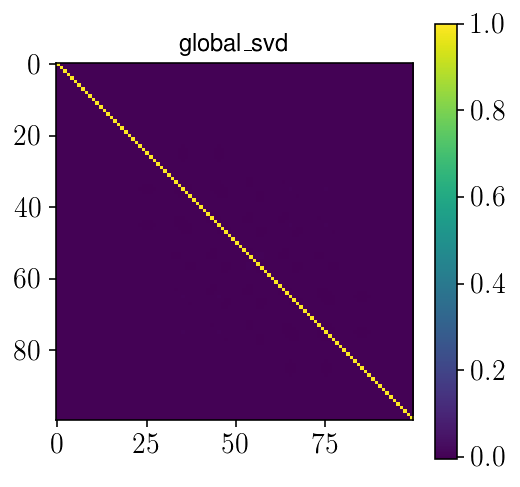

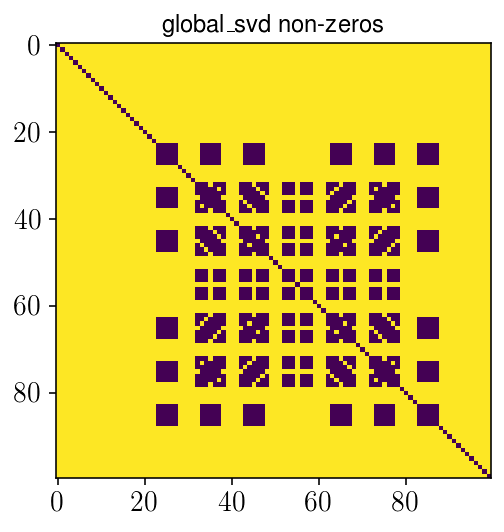

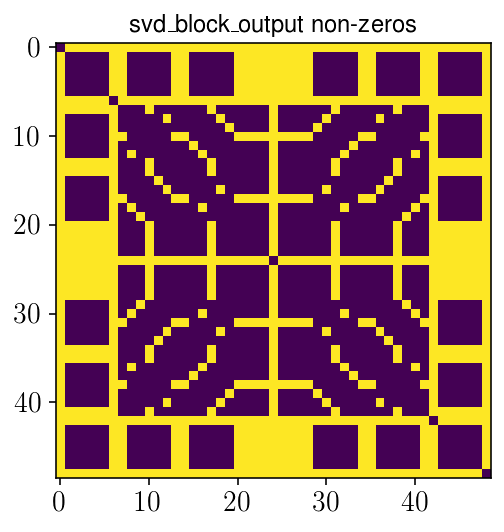

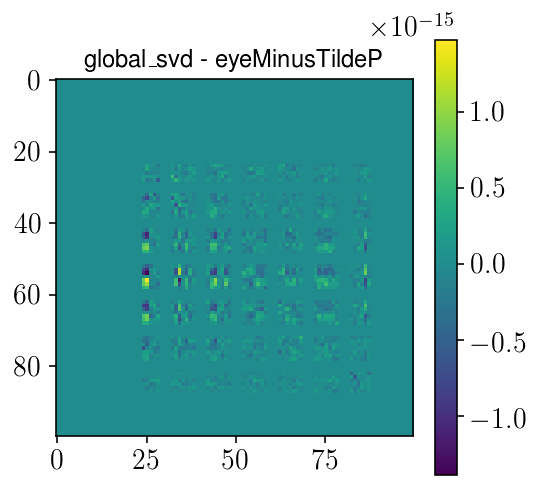

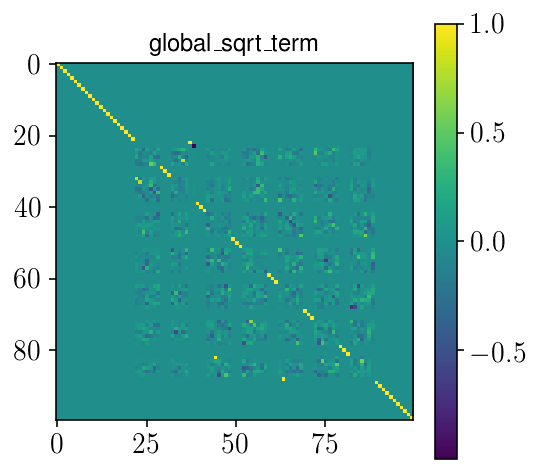

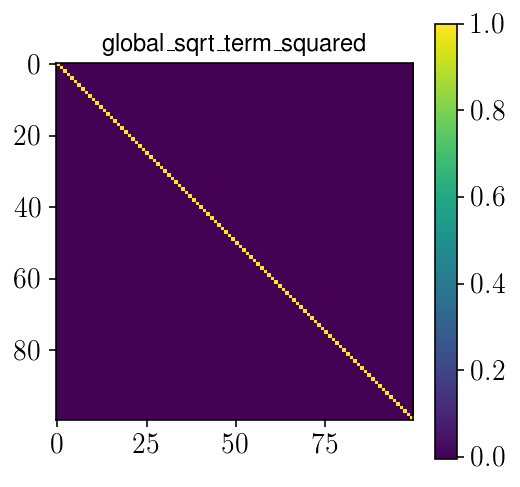

In [17]:
def extendSVDBlock(svd_block, nx, ny, pos_x, pos_y):
    
    # The Q^{1/2} U_GB^T pattern spreads information to a 7x7 cell area, but without the corners
    # Hence, the nonzero structure of tilde{P} should be a block of 7x7-4 = 49-4 = 45 rows and cells.
    
    # Strategy: Fill 49 by 49 area
    
    global_svd = np.eye(nx*ny)
    
    # Read the non-zero structure from tildeP to tildeP_block
    for loc_y_j in range(7):
        global_y_j = pos_y - 3 + loc_y_j
        for loc_x_j in range(7):
            global_x_j = pos_x - 3 + loc_x_j
            
            global_j = global_y_j*nx + global_x_j
            local_j = loc_y_j*7 + loc_x_j
            
            for loc_y_i in range(7):
                global_y_i = pos_y - 3 + loc_y_i
                for loc_x_i in range(7):
                    global_x_i = pos_x - 3 + loc_x_i
                    
                    global_i = global_y_i*nx + global_x_i
                    local_i = loc_y_i*7 + loc_x_i
                    
                    global_svd[global_j, global_i] = svd_block[local_j, local_i]
    return global_svd            
        
global_svd = extendSVDBlock(svd_block_output, nx, ny, pos_x, pos_y)
fig = plt.figure(figsize=(4,4))
plt.imshow(global_svd, interpolation="None")
plt.title("global\_svd ")
plt.colorbar()

fig = plt.figure(figsize=(4,4))
plt.imshow(np.abs(global_svd) < 0.00000001, interpolation="None")
plt.title("global\_svd non-zeros")

fig = plt.figure(figsize=(4,4))
plt.imshow(np.abs(svd_block_output) < 0.00000001, interpolation="None")
plt.title("svd\_block\_output non-zeros")

eyeMinusTildeP = np.eye(nx*ny) - tildeP
fig = plt.figure(figsize=(4,4))
plt.imshow(global_svd - eyeMinusTildeP, interpolation="None")
plt.title("global\_svd - eyeMinusTildeP")
plt.colorbar()

global_sqrt_term = extendSVDBlock(sqrt_term, nx, ny, pos_x, pos_y)
fig = plt.figure(figsize=(4,4))
plt.imshow(global_sqrt_term, interpolation="None")
plt.title("global\_sqrt\_term ")
plt.colorbar()

global_sqrt_term_squared = np.dot(global_sqrt_term, global_sqrt_term.transpose())
fig = plt.figure(figsize=(4,4))
plt.imshow(global_sqrt_term_squared, interpolation="None")
plt.title("global\_sqrt\_term\_squared ")
plt.colorbar()

# Apply local and global $U \Sigma^{1/2}$ to vector
And see that the results are the same.

Dummy diff (should be zero):  0.0
Result diff (should be zero):  7.192390305471551e-16
Diff from multiplying the sqrt_term:  5.485917895908923
0.10473764891980286 0.10473764891980286


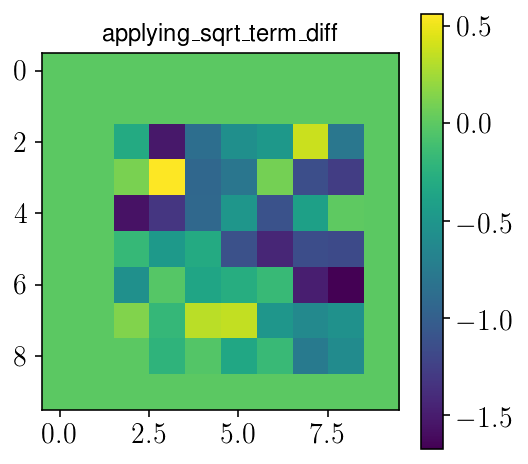

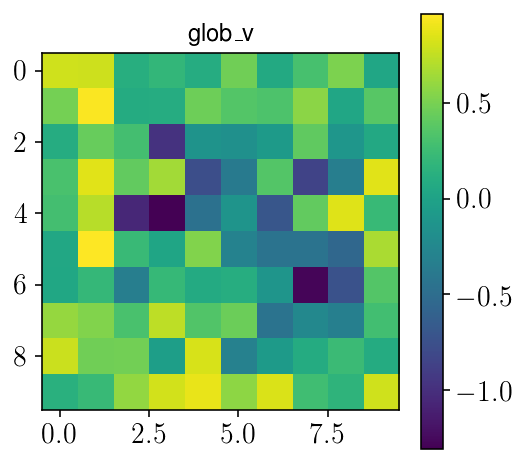

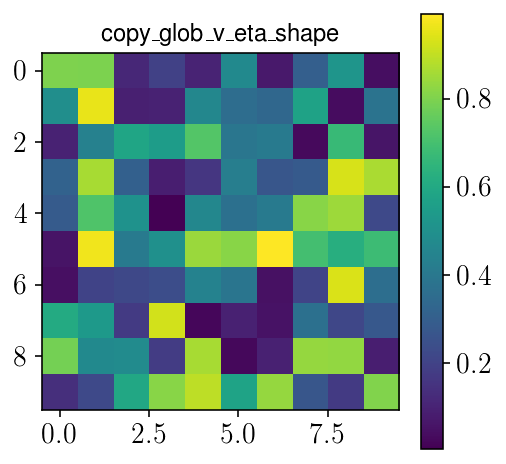

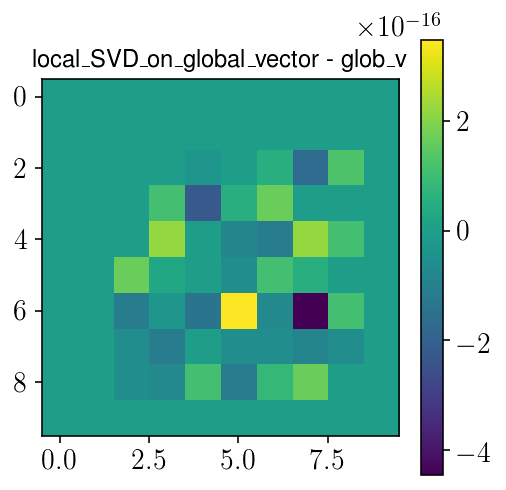

In [18]:
glob_v = np.random.rand(nx*ny)

def global_to_local_vec(glob_vec, nx, ny, pos_x, pos_y):
    
    # Strategy: go from vec nx*ny to vec 49
    
    loc_vec = np.zeros(49)
    
    # Read the non-zero structure from tildeP to tildeP_block
    for loc_y_j in range(7):
        global_y_j = pos_y - 3 + loc_y_j
        for loc_x_j in range(7):
            global_x_j = pos_x - 3 + loc_x_j
            
            global_j = global_y_j*nx + global_x_j
            local_j = loc_y_j*7 + loc_x_j
            
            loc_vec[local_j] = glob_vec[global_j]
    return loc_vec

def write_local_to_global_vec(glob_vec, loc_vec, nx, ny, pos_x, pos_y):
    
    # Write the elements in loc_vec to the appropriate locations in glob_vec
        
    # Read the non-zero structure from tildeP to tildeP_block
    for loc_y_j in range(7):
        global_y_j = pos_y - 3 + loc_y_j
        for loc_x_j in range(7):
            global_x_j = pos_x - 3 + loc_x_j
            
            global_j = global_y_j*nx + global_x_j
            local_j = loc_y_j*7 + loc_x_j
            
            glob_vec[global_j] = loc_vec[local_j]
    
# This is the function that needs to be implemented on GPU
def apply_local_SVD_to_global_eta(local_sqrt_term, global_eta, nx, ny, pos_x, pos_y):
    """
    Despite the bad name, this is a good function!
    
    It takes as input:
     - local sqrt(SVD) as U*sqrt(Sigma) in a (49, 49) buffer 
     - the global xi stored in a (ny, nx) buffer
     
    It returns the product of the first and second argument, as U*sqrt(Sigma)*xi, in a (ny, nx) buffer 
    """
    
    
    # Copy the result (representing the multiplication with I)
    res_global_eta = global_eta.copy()
    
    # Read the non-zero structure from tildeP to tildeP_block
    for loc_y_j in range(7):
        global_y_j = pos_y - 3 + loc_y_j
        for loc_x_j in range(7):
            global_x_j = pos_x - 3 + loc_x_j
            
            global_j = global_y_j*nx + global_x_j
            local_j = loc_y_j*7 + loc_x_j
            
            #loc_vec[local_j] = glob_vec[global_j]
            
            xi_j = 0.0
            for loc_y_i in range(7):
                global_y_i = pos_y - 3 + loc_y_i
                for loc_x_i in range(7):
                    global_x_i = pos_x - 3 + loc_x_i
                    
                    global_i = global_y_i*nx + global_x_i
                    local_i = loc_y_i*7 + loc_x_i
                    
                    xi_j += local_sqrt_term[local_j, local_i]*global_eta[global_y_i, global_x_i]
            
            res_global_eta[global_y_j, global_x_j] = xi_j
            
    return res_global_eta
            
# Check that the above functions works:
loc_v = global_to_local_vec(glob_v, nx, ny, pos_x, pos_y)
copy_glob_v = glob_v.copy()
write_local_to_global_vec(glob_v, loc_v, nx, ny, pos_x, pos_y)
print( "Dummy diff (should be zero): ", np.linalg.norm(glob_v - copy_glob_v))

loc_res = np.dot(sqrt_term, loc_v)
write_local_to_global_vec(glob_v, loc_res, nx, ny, pos_x, pos_y)
fasit = np.dot(global_sqrt_term, copy_glob_v)

print( "Result diff (should be zero): ", np.linalg.norm(glob_v - fasit))
print( "Diff from multiplying the sqrt_term: ", np.linalg.norm(glob_v - copy_glob_v))
applying_sqrt_term_diff = glob_v - copy_glob_v

applying_sqrt_term_diff = applying_sqrt_term_diff.reshape((ny,nx))
fig = plt.figure(figsize=(4,4))
plt.imshow(applying_sqrt_term_diff, interpolation="None")
plt.title("applying\_sqrt\_term\_diff ")
plt.colorbar()

glob_v = glob_v.reshape((ny,nx))
fig = plt.figure(figsize=(4,4))
plt.imshow(glob_v, interpolation="None")
plt.title("glob\_v")
plt.colorbar()

copy_glob_v_eta_shape = copy_glob_v.reshape((ny,nx))
fig = plt.figure(figsize=(4,4))
plt.imshow(copy_glob_v_eta_shape, interpolation="None")
plt.title("copy\_glob\_v\_eta\_shape")
plt.colorbar()

print( copy_glob_v_eta_shape[0,4], copy_glob_v[4])

# Testing the function that will be implemented on GPU
local_SVD_on_global_vector = apply_local_SVD_to_global_eta(sqrt_term, copy_glob_v_eta_shape, nx, ny, pos_x, pos_y) 
fig = plt.figure(figsize=(4,4))
plt.imshow(local_SVD_on_global_vector - glob_v, interpolation="None")
plt.title("local\_SVD\_on\_global\_vector - glob\_v ")
plt.colorbar()

# Creating matrix $S = (HQH^T + R)^{-1}$
$$S = (H U_{GB} \tilde{Q}^{1/2} \tilde{Q}^{1/2} U_{GB}^T + R)^{-1}$$

10 10 4.0 4.0 5 5 0.00028492202 3.0
g*H/(f*2*dx) 245.2500116042791
U_GB.shape:  (300, 100)
HQHT
[[1.90682761e-02 1.08420217e-19]
 [1.08420217e-19 1.90682761e-02]]
S from matrix multiplications: 
[[ 5.18315291e+01 -2.91271717e-16]
 [-2.91271717e-16  5.18315291e+01]]
S from createS function: 
[[ 9.6971326e+02 -2.1731816e-14]
 [-4.0958369e-13  9.6971326e+02]]
np.max(ensemble.base_H) 10.0


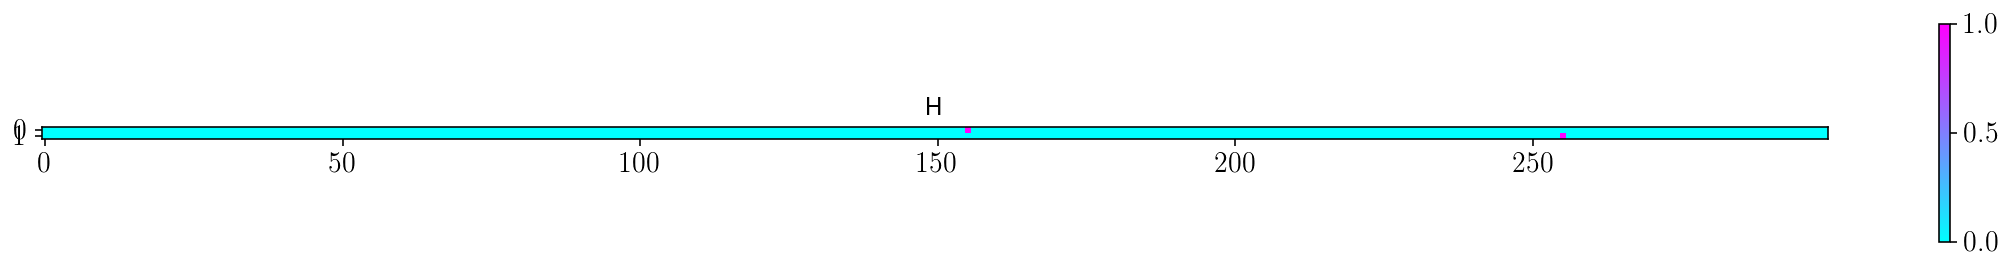

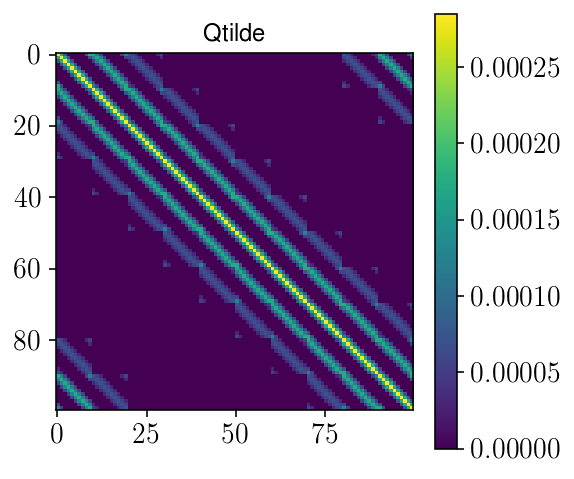

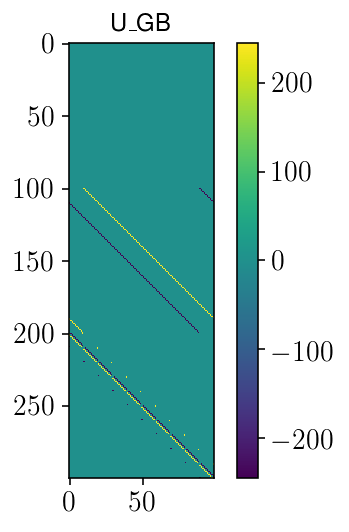

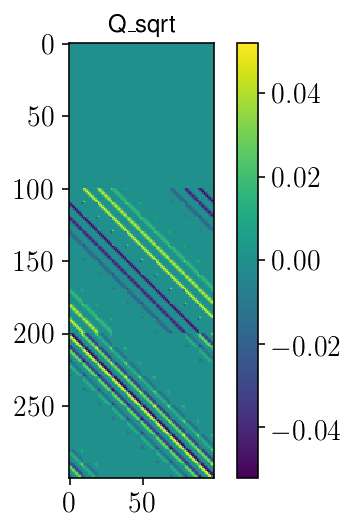

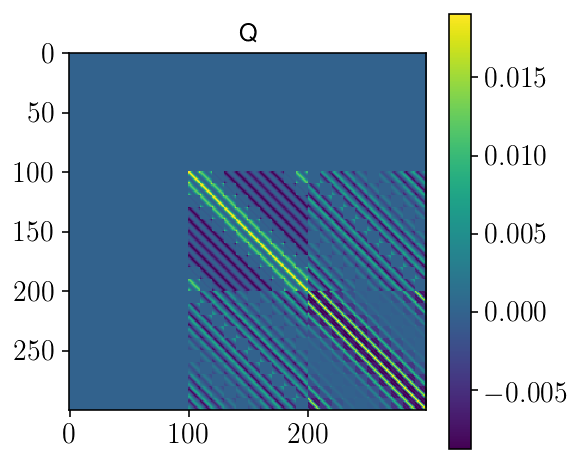

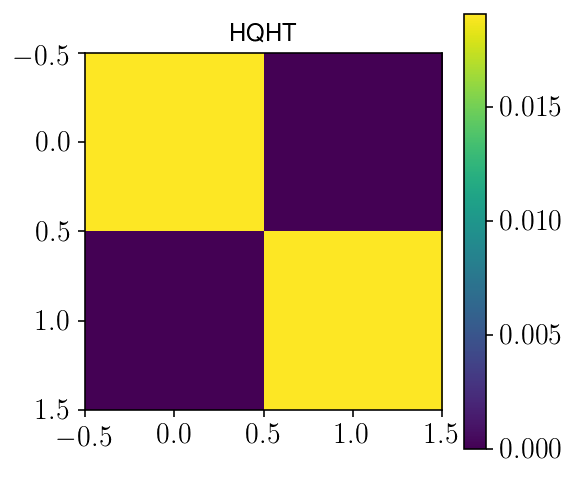

In [19]:
print (nx, ny, ensemble.dx, ensemble.dy, pos_x, pos_y, q0, L)

H = createMatrixH(nx, ny, pos_x, pos_y)
Qtilde = createCutoffMatrixQ(nx, ny, dx=ensemble.dx, dy=ensemble.dy, L=0.75*dx, q0=q0)
U_GB = createUGBmatrix(nx, ny, g=ensemble.g, H=np.max(ensemble.base_H), f=ensemble.f, dx=ensemble.dx, dy=ensemble.dy)

print ("g*H/(f*2*dx)", ensemble.g*np.max(ensemble.base_H)/(ensemble.f*2*ensemble.dx))

fig = plt.figure(figsize=(20,2))
plt.imshow(H, interpolation="None", cmap="cool")
plt.title("H")
plt.colorbar()

fig = plt.figure(figsize=(4,4))
plt.imshow(Qtilde, interpolation="None")
plt.title("Qtilde")
plt.colorbar()

fig = plt.figure(figsize=(4,4))
plt.imshow(U_GB, interpolation="None")
plt.title("U\_GB")
plt.colorbar()
print ("U_GB.shape: ", U_GB.shape)

Q_sqrt = np.dot(U_GB, Qtilde)
fig = plt.figure(figsize=(4,4))
plt.imshow(Q_sqrt, interpolation="None")
plt.title("Q\_sqrt")
plt.colorbar()

Q = np.dot(Q_sqrt, Q_sqrt.transpose())
fig = plt.figure(figsize=(4,4))
plt.imshow(Q, interpolation="None")
plt.title("Q")
plt.colorbar()

HQHT = np.dot(H, np.dot(Q, H.transpose()))
fig = plt.figure(figsize=(4,4))
plt.imshow(HQHT, interpolation="None")
plt.title("HQHT")
plt.colorbar()
print ("HQHT")
print (HQHT)

print ("S from matrix multiplications: ")
print (np.linalg.inv(HQHT + ensemble.observation_cov))

debug=False
tmp_iewpf = IEWPFOcean.IEWPFOcean(ensemble)
S = tmp_iewpf.S_host
print ("S from createS function: ")
print (S)

print ("np.max(ensemble.base_H)", np.max(ensemble.base_H))